In [1]:
import os, sys
import importlib
import matplotlib.pyplot as plt 
import numpy as np
sys.path.insert(0, os.path.abspath("../../hi-ml/src"))
sys.path.insert(0, os.path.abspath("../../hi-ml-azure/src"))
from histopathology.datasets.panda_tiles_dataset import PandaTilesDataset
from health_ml.utils.bag_utils import BagDataset
import histopathology.datamodules.panda_module as panda_module
import histopathology.configs.classification.DeepSMILEPanda as mil_configs
from histopathology.datasets.base_dataset import SlidesDataset
from histopathology.models.transforms import LoadTilesBatchd
from monai.data.dataset import Dataset
import matplotlib.pyplot as plt

Failure while loading azureml_run_type_providers. Failed to load entrypoint automl = azureml.train.automl.run:AutoMLRun._from_run_dto with exception (cloudpickle 2.0.0 (/home/t-kbouzid/miniconda3/envs/HimlHisto/lib/python3.7/site-packages), Requirement.parse('cloudpickle<2.0.0,>=1.1.0'), {'azureml-dataprep'}).


In [2]:
data_root = "/tmp/datasets"
panda_tiles_root = os.path.join(data_root, "PANDA_tiles")
panda_wsi_root = os.path.join(data_root, "PANDA")
root = "~/workspace/repos/hi-ml/hi-ml-histopathology/src/histopathology/configs/classification"
train_csv = os.path.join(root, "custom_subset/panda/train_tiles_20.csv")
val_csv = os.path.join(root, "custom_subset/panda/val_tiles_5.csv")

## Tiles Exploration

### Data Modules

In [3]:
tiles_ds = PandaTilesDataset(root=panda_tiles_root, dataset_csv=train_csv)
bag_ds = BagDataset(tiles_ds,
                    bag_ids=tiles_ds.slide_ids,
                    shuffle_samples=True)
bag_ds.__getitem__(0).keys()

dict_keys(['tile_id', 'slide_id', 'mask', 'tile_x', 'tile_y', 'occupancy', 'data_provider', 'slide_isup_grade', 'slide_gleason_score', 'image', 'image_path'])

In [4]:
len(bag_ds.__getitem__(0)["image"])

61

In [5]:
transform = LoadTilesBatchd(tiles_ds.IMAGE_COLUMN, allow_missing_keys=True)
dataset = Dataset(bag_ds)
out = transform(dataset.__getitem__(1))
out["image"].shape

torch.Size([65, 3, 224, 224])

### MIL Module

In [6]:
importlib.reload(mil_configs)
mil_test = mil_configs.SubPandaImageNetMIL()
mil_test.setup()
deepmil_module = mil_test.create_model()

/home/t-kbouzid/miniconda3/envs/HimlHisto/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [4]:
deepmil_module.encoder.input_dim

(512,)

In [20]:
encoder = mil_test.get_encoder()
print(encoder.input_dim)

(3, 224, 224)


In [21]:
embedding = encoder(out["image"])
embedding.shape

torch.Size([65, 512])

In [22]:
data_module = mil_test.get_data_module()

In [23]:
train, test, val = data_module.get_splits()

In [24]:
bag = data_module._load_dataset(train, stage="train", shuffle=False)

Loading dataset from /tmp/innereye_cache1/SubPandaImageNetMIL-ImageNetEncoder/train_dataset.pt into cpu


## Whole Slide Loading test

In [15]:
importlib.reload(panda_module)
train_csv = os.path.join(root, "custom_subset/panda/train_slides_20.csv")
val_csv = os.path.join(root, "custom_subset/panda/val_slides_5.csv")
wsi_data_module = panda_module.SubPandaSlidesDataModule(root_path=panda_wsi_root,train_csv=train_csv, val_csv=val_csv, batch_size=4, tile_count=56, tile_size=224)

In [16]:
train, test, val = wsi_data_module.get_splits()

In [6]:
train.__getitem__(0)

{<SlideKey.SLIDE_ID: 'slide_id'>: '0005f7aaab2800f6170c399693a96917',
 <SlideKey.IMAGE: 'image'>: '/tmp/datasets/PANDA/train_images/0005f7aaab2800f6170c399693a96917.tiff',
 <SlideKey.IMAGE_PATH: 'image_path'>: '/tmp/datasets/PANDA/train_images/0005f7aaab2800f6170c399693a96917.tiff',
 <SlideKey.MASK: 'mask'>: '/tmp/datasets/PANDA/train_label_masks/0005f7aaab2800f6170c399693a96917_mask.tiff',
 <SlideKey.MASK_PATH: 'mask_path'>: '/tmp/datasets/PANDA/train_label_masks/0005f7aaab2800f6170c399693a96917_mask.tiff',
 <SlideKey.LABEL: 'label'>: 0,
 <SlideKey.METADATA: 'metadata'>: {'data_provider': 'karolinska',
  'isup_grade': 0,
  'gleason_score': '0+0'}}

In [7]:
wsi_dataset = wsi_data_module._load_dataset(stage="train")

In [8]:
len(wsi_dataset.__getitem__(0))

[Plugin: cucim.kit.cuslide] Loading the dynamic library from: /home/t-kbouzid/miniconda3/envs/HimlHisto/lib/python3.7/site-packages/cucim/clara/cucim.kit.cuslide@22.02.00.so
Initializing plugin: cucim.kit.cuslide (interfaces: [cucim::io::IImageFormat v0.1]) (impl: cucim.kit.cuslide)
[Plugin: cucim.kit.cumed] Loading the dynamic library from: /home/t-kbouzid/miniconda3/envs/HimlHisto/lib/python3.7/site-packages/cucim/clara/cucim.kit.cumed@22.02.00.so
Initializing plugin: cucim.kit.cumed (interfaces: [cucim::io::IImageFormat v0.1]) (impl: cucim.kit.cumed)


56

In [9]:
data_loader = wsi_data_module._get_dataloader(stage="train", shuffle=True)

In [10]:
X_d = next(iter(data_loader))

In [15]:
X_d["image"].shape

torch.Size([4, 56, 3, 224, 224])

In [16]:
X_d.keys()

dict_keys([<SlideKey.SLIDE_ID: 'slide_id'>, <SlideKey.IMAGE: 'image'>, <SlideKey.IMAGE_PATH: 'image_path'>, <SlideKey.MASK: 'mask'>, <SlideKey.MASK_PATH: 'mask_path'>, <SlideKey.LABEL: 'label'>, <SlideKey.METADATA: 'metadata'>])

In [17]:
X_d["label"]

tensor([5, 0, 0, 0])

In [18]:
X_d["metadata"]

{'data_provider': ['radboud', 'radboud', 'radboud', 'karolinska'],
 'isup_grade': tensor([5, 0, 0, 0]),
 'gleason_score': ['4+5', 'negative', 'negative', '0+0']}

In [14]:
type(X_d["image"][0, 1, ...])

torch.Tensor

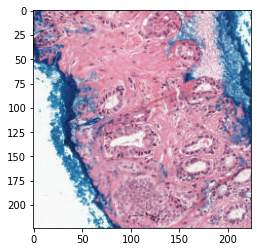

In [28]:
plt.imshow(X_d["image"][0, 10, ...].transpose(0,1).transpose(1,2))

## Test with mock data

In [77]:
importlib.reload(panda_module)
mock_wsi_root = "/home/t-kbouzid/workspace/repos/hi-ml/hi-ml-histopathology/testhisto/test_data/whole_slide_images/pathmnist"
train_csv = os.path.join(mock_wsi_root, "dataset.csv")
val_csv = os.path.join(mock_wsi_root, "dataset.csv")
wsi_data_module = panda_module.SubPandaSlidesDataModule(root_path=mock_wsi_root,train_csv=train_csv, val_csv=val_csv, batch_size=1, tile_count=16, tile_size=28, level=0)

In [112]:
from typing import Any, Union, Optional, Tuple
from pathlib import Path
import pandas as pd
from histopathology.datamodules.base_module import SlidesDataModule

class MockSlidesDataset(SlidesDataset):
    SLIDE_ID_COLUMN = "image_id"
    IMAGE_COLUMN = "image"
    LABEL_COLUMN = "isup_grade"

    METADATA_COLUMNS = ("data_provider", "isup_grade", "gleason_score")

    def __init__(
        self,
        root: Union[str, Path],
        dataset_csv: Optional[Union[str, Path]] = None,
        dataset_df: Optional[pd.DataFrame] = None,
    ) -> None:
        super().__init__(root, dataset_csv, dataset_df, validate_columns=False)
        slide_ids = self.dataset_df.index
        self.dataset_df[self.IMAGE_COLUMN] = slide_ids + ".tiff"
        self.validate_columns()


class MockSlidesDataModule(SlidesDataModule):
    def __init__(self, **kwargs: Any) -> None:
        super().__init__(**kwargs)

    def get_splits(self) -> Tuple[MockSlidesDataset, MockSlidesDataset, MockSlidesDataset]:
        return (MockSlidesDataset(self.root_path), MockSlidesDataset(self.root_path), MockSlidesDataset(self.root_path))

In [118]:
root_path = mock_wsi_root
datamodule = MockSlidesDataModule(root_path=root_path, batch_size=1, tile_count=16, tile_size=28, level=0)
dataloader = datamodule.train_dataloader()

In [119]:
sample = next(iter(dataloader))
tiles = sample["image"]
wsi_id = sample["slide_id"][0]
patches = np.array([np.load(os.path.join(root_path, wsi_id, f"patch_{i}.npy")) for i in range(4)])
assert tiles.shape == (1, 16, 3, 28, 28)
for i in range(0, 16, 4):
    assert (patches[i // 4] == tiles[0, i].numpy()).all()

In [115]:
[os.path.join(wsi_id, f"patch_{i}.npy") for i in range(4)]

['_1/patch_0.npy', '_1/patch_1.npy', '_1/patch_2.npy', '_1/patch_3.npy']

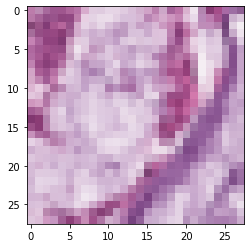

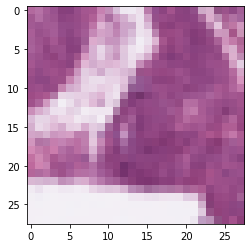

In [100]:
import matplotlib.pyplot as plt
plt.imshow(patches[0].transpose((1, 2, 0)))
plt.show()
plt.imshow(tiles[0, 0].numpy().transpose((1, 2, 0)))
plt.show()

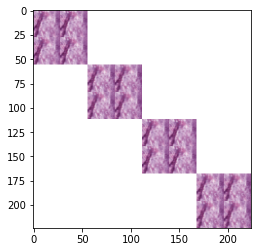

In [117]:
from tifffile import imread
wsi = imread(os.path.join(root_path, f"{wsi_id}.tiff"))
plt.imshow(wsi)

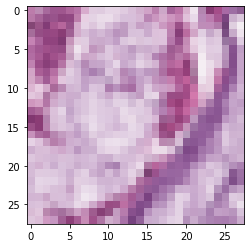

In [103]:
plt.imshow(wsi[:28, :28])

In [104]:
patches[0].transpose((1, 2, 0)).shape
wsi[:28, :28].shape

(28, 28, 3)

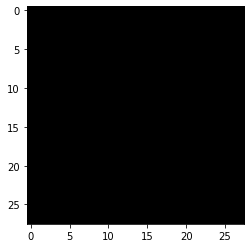

In [105]:
ori = patches[0].transpose((1, 2, 0))
diff = wsi[:28, :28] - ori
plt.imshow(diff)

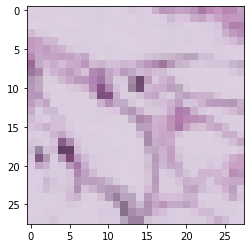

In [90]:
plt.imshow(patches[0].transpose((1, 2, 0)))
plt.show()

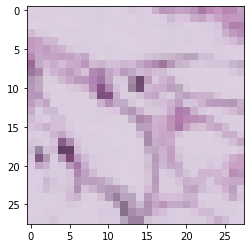

In [94]:
plt.imshow(tiles[0, 12].numpy().transpose((1, 2, 0)))
plt.show()

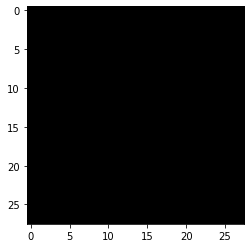

In [95]:
diff = patches[0] - tiles[0, 12].numpy()
plt.imshow(diff.transpose((1, 2, 0)))

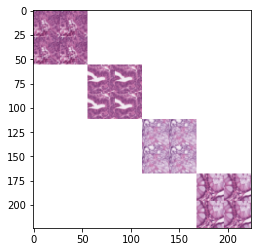

In [111]:
from tifffile import imread
wsi = imread(os.path.join(root_path, f"{wsi_id}.tiff"))
plt.imshow(wsi)

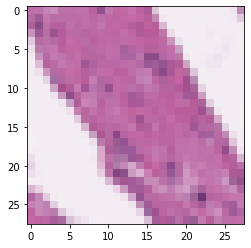

In [110]:
plt.imshow(tiles[0, 12].numpy().transpose((1, 2, 0)))
plt.show()